# Kaggle Titanic
[데이터 다운로드](https://www.kaggle.com/competitions/titanic/data)


코드 부분은 지우고 결과 부분만 남겨 뒀습니다.  
남아있는 결과와 동일하게 출력될 수 있도록 코드를 작성해보세요!  

### 사용 라이브러리

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

### Data Load

In [4]:
train = pd.read_csv("data/train.csv", encoding="utf-8")
train.shape

(891, 12)

### 기본 정보

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 결측치 확인

<AxesSubplot: >

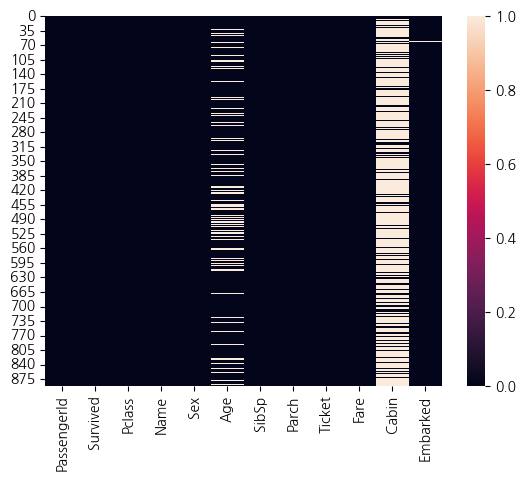

In [6]:
sns.heatmap(train.isnull())

In [7]:
train[['Age','Cabin','Embarked']].isnull().mean()

Age         0.198653
Cabin       0.771044
Embarked    0.002245
dtype: float64

### 생존자

<AxesSubplot: xlabel='Survived', ylabel='count'>

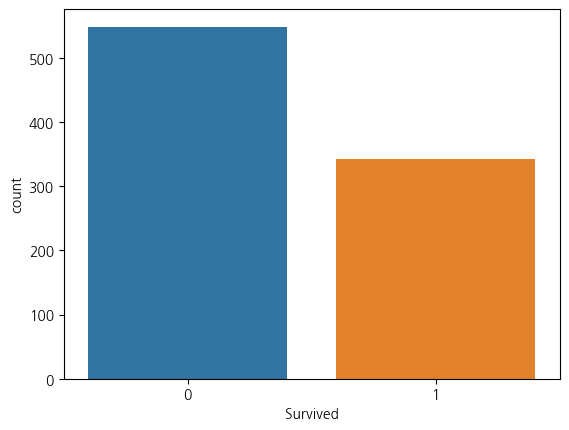

In [8]:
sns.countplot(data=train, x='Survived')

<AxesSubplot: xlabel='Survived', ylabel='count'>

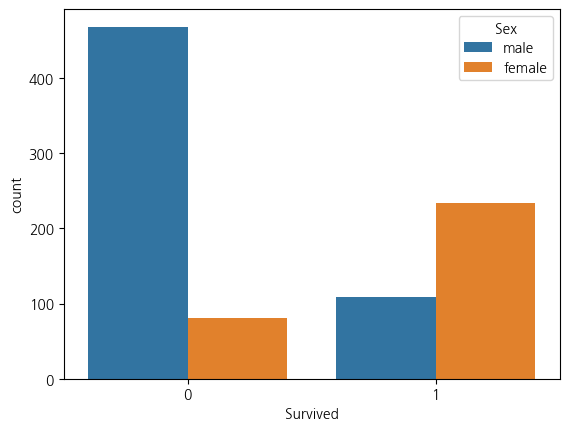

In [9]:
sns.countplot(data=train, x='Survived', hue='Sex')

<AxesSubplot: xlabel='Survived', ylabel='count'>

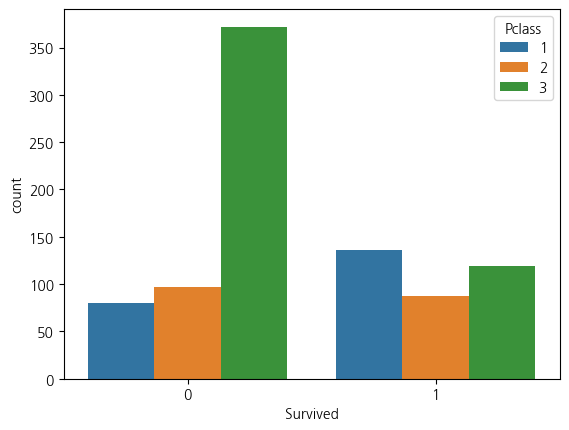

In [10]:
sns.countplot(data=train, x='Survived', hue='Pclass')

### Data Cleaning
#### Age

<AxesSubplot: xlabel='Pclass', ylabel='Age'>

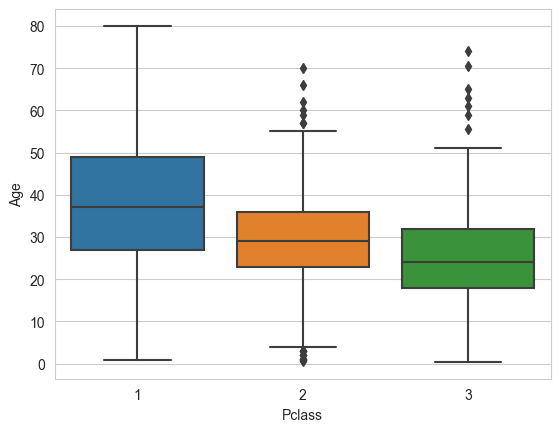

In [11]:
sns.set_style("whitegrid")
sns.boxplot(data=train, x='Pclass', y='Age')

In [12]:
train.groupby('Pclass')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,186.0,38.233441,14.802856,0.92,27.0,37.0,49.0,80.0
2,173.0,29.877630,14.001077,0.67,23.0,29.0,36.0,70.0
3,355.0,25.140620,12.495398,0.42,18.0,24.0,32.0,74.0


결측치가 있는 `Age`를 `Pclass`의 평균 나이값을 이용해 대채

In [49]:
age_means = train.groupby('Pclass')['Age'].describe()['mean']
age_means

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: mean, dtype: float64

In [50]:
def age_pclass(cols):
    age_means = train.groupby('Pclass')[cols].describe()['mean']
    train.loc[(train["Pclass"]==1) & (train[cols].isnull()), cols] = age_means[1]
    train.loc[(train["Pclass"]==2) & (train[cols].isnull()), cols] = age_means[2]
    train.loc[(train["Pclass"]==3) & (train[cols].isnull()), cols] = age_means[3]

In [51]:
# age_pclass 함수를 이용해 Age 결측치 채우기
age_pclass('Age')

In [52]:
train["Age"].isnull().sum()

0

#### 범주형 데이터 변환

범주형 데이터는 학습에서 바로 사용이 불가능하기 때문에 수치형으로 변환이 필요합니다.  
예를 들어, `Sex`의 경우 `Male=0`, `Female=1`과 같이 변환을 합니다.

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


현재 범주형 데이터는, `Name, Sex, Ticket, Embarked`가 있음

#### pd.get_dummies
학습 이전에 모든 데이터를 수치로 변환해주는 전처리 작업이 필요함  
1. 수치형 데이터로 변환
2. 수치화된 데이터를 가변수화

##### Note!!! - 가변수화
수치형 데이터로만 변환하면, **서로 간의 관계성**이 생기게 되어버림
- 월, 화, 수 ... -> 1, 2, 3 ...
- 1+2=3 / 월+화=수라는 관계성이 성립해버림

`pandas`의 `get_dummies` 함수는 원핫인코딩을 이용하는 방식  
`get_dummies(data=, prefix=, prefix_sep=, dummy_na=, columns=, drop_first=, dtype=)` 형식으로 존재함
- data: one-hot encoding을 적용할 데이터
- prefix: 생성할 더미 데이터(가변수화된 데이터)의 컬럼 prefix
- prefix_sep: `default='_'`
- dummpy_na: `NaN`도 포함시킬지, `default=False`
- columns: 대상 컬럼
- drop_first: k개의 범주를 k-1개로 가변수화할 경우 사용
- dtype: 새로운 columns의 데이터 타입

In [38]:
pd.get_dummies(train, columns = ["Sex", "Embarked"])

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,NaN,0,1,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,1,0,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,1,2,W./C. 6607,23.4500,NaN,1,0,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,C148,0,1,1,0,0


In [34]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [37]:
train_dummies = pd.get_dummies(train, columns = ["Sex", "Embarked"])
train_dummies = train_dummies.drop(columns = ["Name", "Ticket", "Cabin", "Sex_female", "Embarked_C"])
train_dummies = train_dummies.rename(columns={'Embarked_Q':'Q','Embarked_S':'S','Sex_male':'male'})
train_dummies

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,13.0000,1,0,1
887,888,1,1,19.0,0,0,30.0000,0,0,1
888,889,0,3,NaN,1,2,23.4500,0,0,1
889,890,1,1,26.0,0,0,30.0000,1,0,0


In [45]:
'PassengerId','Survived', 'Age', 'SibSp', 'Parch', 'Fare',

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1
